<font size="5">Variational Bayes time series clustering and Generative model</font>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_3d

Testing a small universe of the 10Y Treasury, an Oil ETF, and Tech ETF. The goal will be to cluster the time series into different states based on their mean and covariance, then view synthetic data sampled from each state in isolation using two different methods: a GaussianMultivariate instance (copula) and sampling from the BayesianGaussianMixture model. 

In [2]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets.

In [3]:
m6 = pd.read_csv('./data/assets_m6.csv')
m6_subset = pd.DataFrame()

for sym in assetlist: 
    m6_subset[sym] = m6[m6['symbol'] == sym]['price'].values

Log return of each asset.  

In [4]:
m6_subset = m6_subset.apply(np.log).apply(np.diff).dropna()
print(m6_subset)

          IEF       GSG       IXN
0   -0.001353  0.007295  0.003029
1    0.002047  0.003110  0.007333
2   -0.004270  0.004132 -0.030381
3   -0.007710  0.013822  0.004786
4    0.000273 -0.002036 -0.007351
..        ...       ...       ...
193 -0.003539 -0.006549  0.016234
194  0.006638 -0.017230  0.011501
195  0.003409 -0.027102 -0.023824
196  0.022192  0.008208  0.078576
197 -0.002082  0.018002  0.022459

[198 rows x 3 columns]


Instantiate a non-parametric clustering model using the dirichlet process. 

In [5]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, weight_concentration_prior_type='dirichlet_process')
dpgmm_model.fit(m6_subset)

BayesianGaussianMixture(n_components=99)

In [6]:
states = dpgmm_model.predict(m6_subset)
m6_subset['state'] = states 

Visualize the states in isolation using the compare3d function, 

In [7]:
def resample_multivariate_gaussian(M=0):
    
    # Resample a specific state to view the mean and covariance characteristics of that state in isolation. First
    # we use the dpgmm model sampling method and then we use the copula sampling method, as a comparison of them. 
    
    state_match = m6_subset[m6_subset['state'] == M].drop(columns=['state']) 
    if len(state_match) <= 1:
        return 
    
    # Get data points only within the current state 
    
    state_match = state_match.rename(columns={'IEF':0,'GSG':1,'IXN':2})
    state_model = mix.BayesianGaussianMixture(n_components=len(state_match), weight_concentration_prior_type='dirichlet_process')
    state_model.fit(state_match)
    
    # Sample from the fitted distribution of matches 
    
    samples, _ = state_model.sample(len(state_match))
    get_col = lambda N: [ s[N] for s in samples ]

    samples_df = pd.DataFrame()
    samples_df[0] = get_col(0) 
    samples_df[1] = get_col(1) 
    samples_df[2] = get_col(2) 
    
    # Fit Copula 
    
    copula = GaussianMultivariate()
    copula.fit(state_match)
    copula_samples = copula.sample(len(state_match))
    
    # Visualize 
    
    fig,ax=plt.subplots(2)
    
    sns.lineplot(data=samples_df[0].cumsum(), label='IEF', ax=ax[0])
    sns.lineplot(data=samples_df[1].cumsum(), label='GSG', ax=ax[0])
    sns.lineplot(data=samples_df[2].cumsum(), label='IXN', ax=ax[0])
    
    sns.lineplot(data=copula_samples[0].cumsum(), label='IEF', ax=ax[1])
    sns.lineplot(data=copula_samples[1].cumsum(), label='GSG', ax=ax[1])
    sns.lineplot(data=copula_samples[2].cumsum(), label='IXN', ax=ax[1])
    
    ax[0].set_title('Variational Bayes sampler')
    ax[1].set_title('Copula sampler')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    compare_3d(state_match, copula_samples)
    compare_3d(state_match, samples_df)

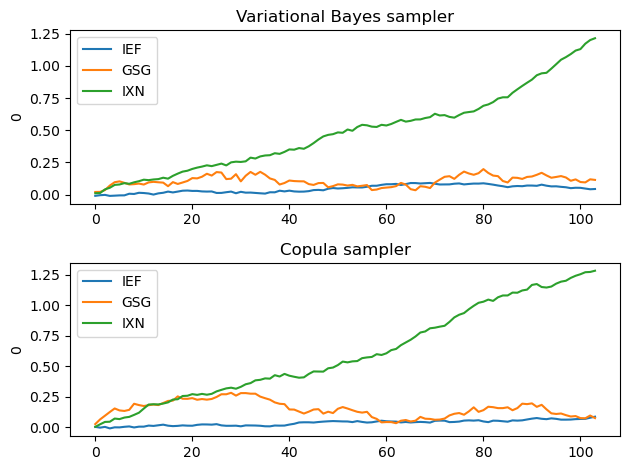

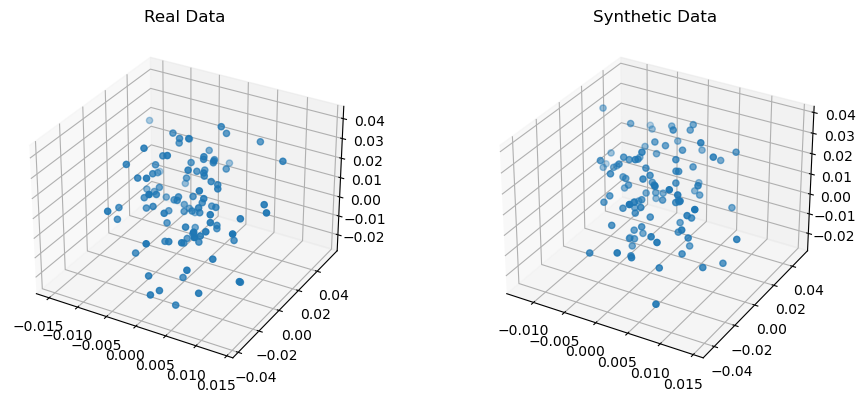

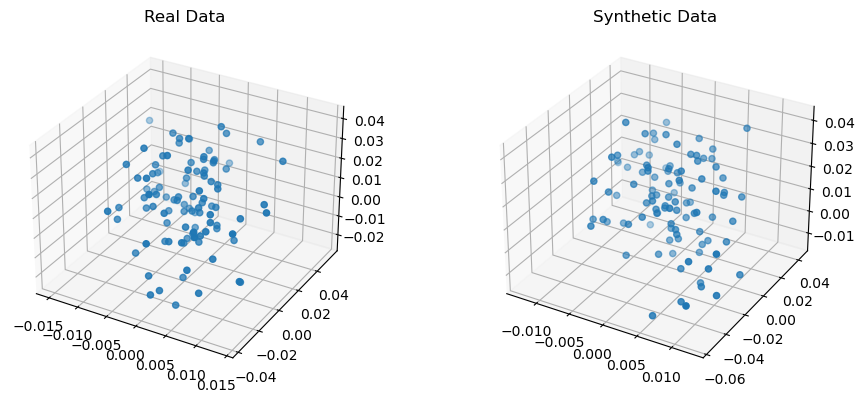

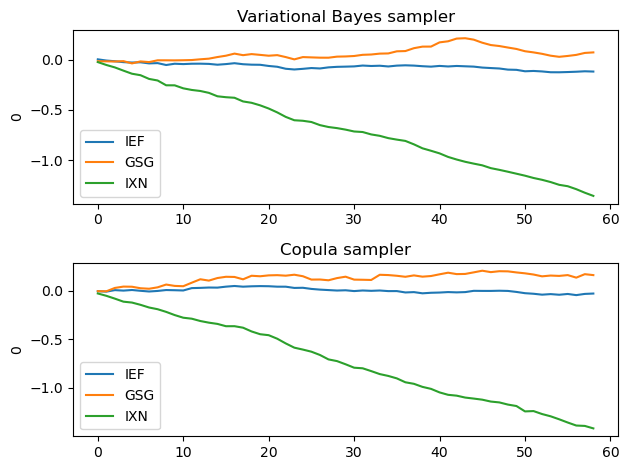

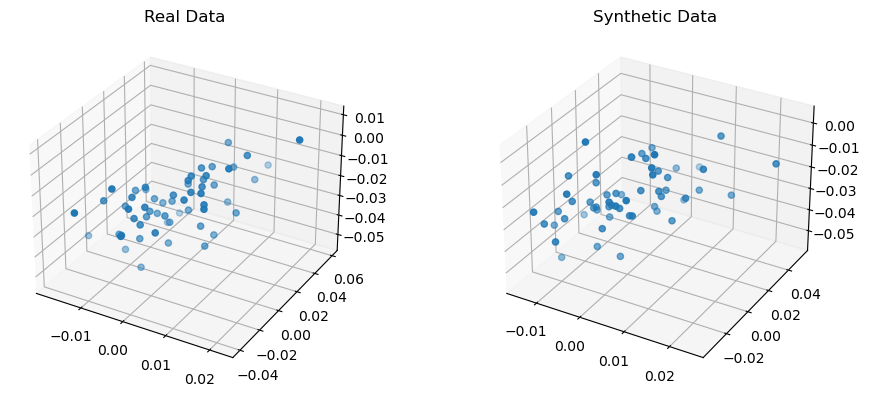

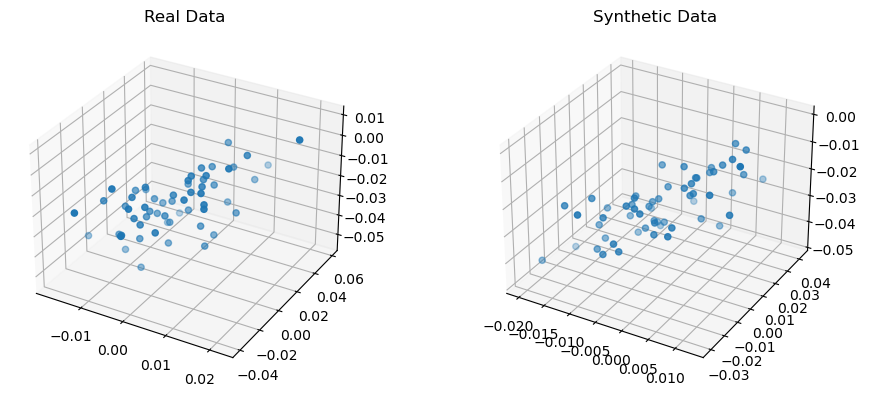

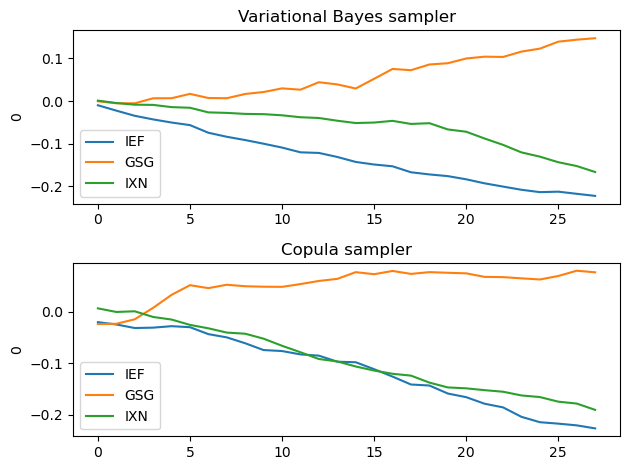

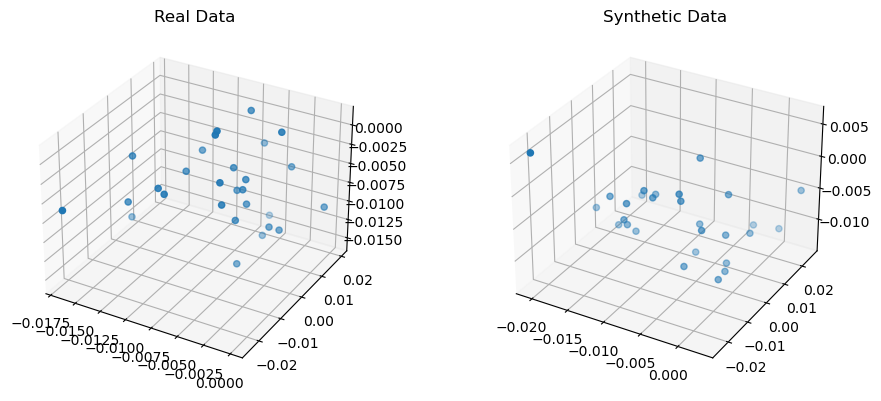

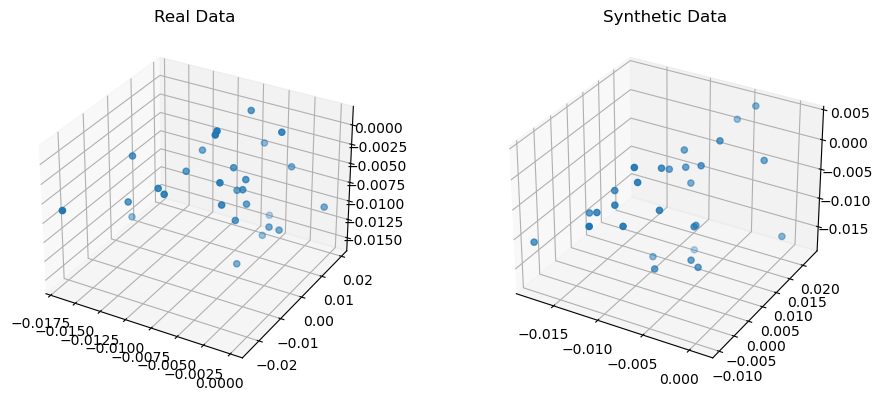

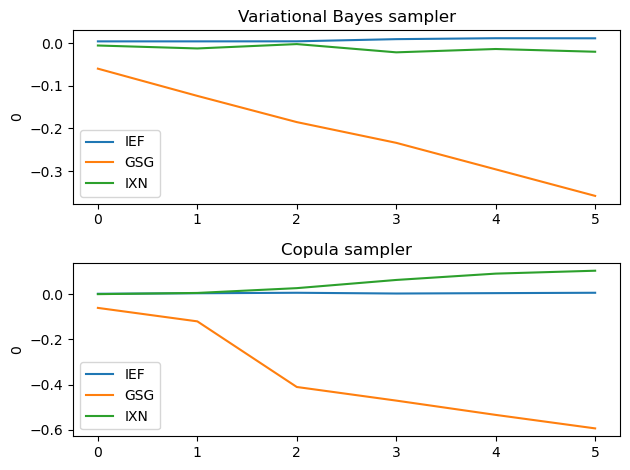

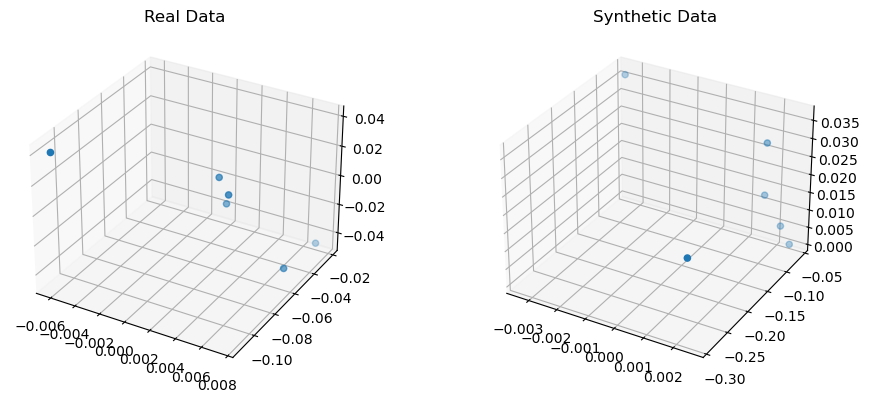

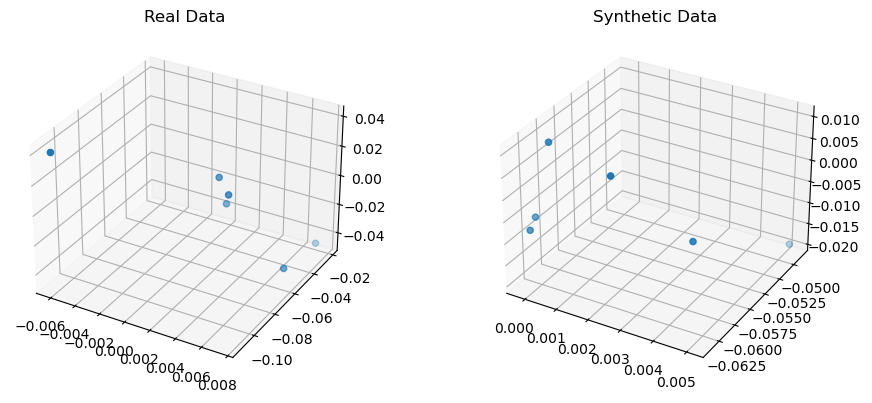

In [8]:
for M in m6_subset['state'].unique():
    resample_multivariate_gaussian(M)